In [84]:
#libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
pd.options.mode.chained_assignment = None
import h2o
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#libraries we need
# !pip install h2o

from scipy.special import expit
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from h2o.estimators import H2OGradientBoostingEstimator
SEED  = 1111   # global random seed for better reproducibility

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# conda install -c conda-forge pydotplus

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress() 

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 hours 51 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_zhangmaojn_tjj23l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.15 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [85]:
train = pd.read_csv('adult.data.txt',
                    names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])

In [86]:
test = pd.read_csv('adult.test.txt',
                    names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])

In [87]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [88]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [89]:
train.shape

(32561, 15)

In [90]:
test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [91]:
## USE THE ABOVE TO REMOVE THE '?'

Replace all entries that contains ? with Null

In [92]:
train=train.replace(' ?', np.nan)

test=test.replace(' ?', np.nan)

Fill Null with 'None' type

In [93]:
train.update(train[['native-country','occupation','workclass']].fillna('None'))
test.update(test[['native-country','occupation','workclass']].fillna('None'))

In [94]:
train.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

In [95]:
test.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

train.head()

test.head()

In [15]:
train.to_csv('train.csv',index=False)

In [16]:
test.to_csv('test.csv',index=False)

## GLM

GLM can produce two categories of models: classification and regression.

Logistic regression is the GLM performing binary classification.

In [21]:
hf=h2o.H2OFrame(train)
gf=h2o.H2OFrame(test)

In [18]:
response_col = 'class'
predictors = list(train.columns.values)
predictors.remove('class')

In [19]:
glm_model = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,remove_collinear_columns=True)
glm_model.train(predictors, response_col, training_frame= hf,validation_frame=gf)

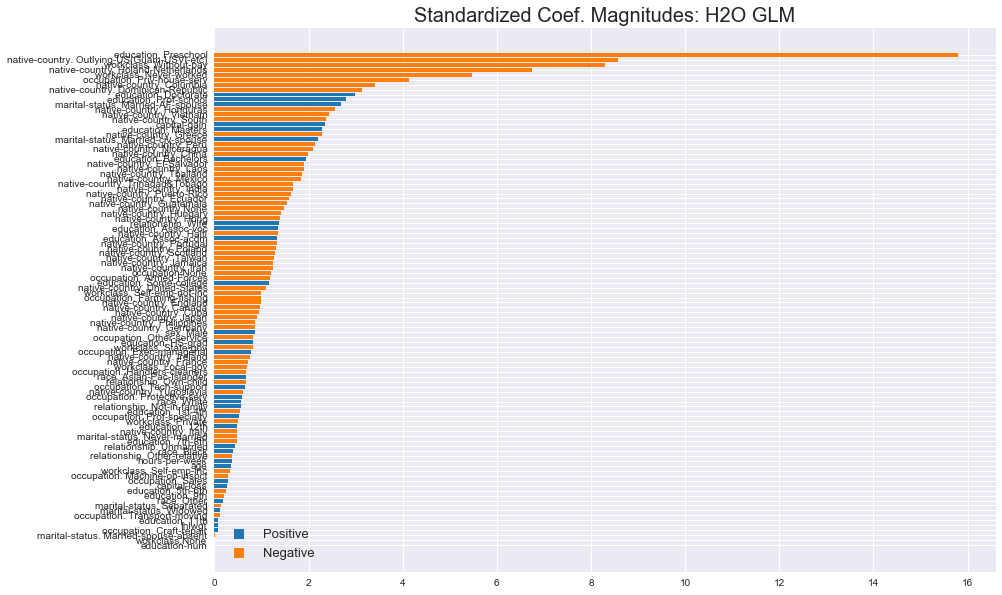

In [20]:
glm_model.std_coef_plot()

In [21]:
glm_model

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1594065615584_1


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,None,100,98,8,Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.10106348033611579
RMSE: 0.31790482905441336
LogLoss: 0.315792344968135
Null degrees of freedom: 32560
Residual degrees of freedom: 32462
Null deviance: 35948.079435207605
Residual deviance: 20565.02908901489
AIC: 20763.02908901489
AUC: 0.9088752373735435
AUCPR: 0.7712473241115264
Gini: 0.817750474747087

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37674918983051864: 


,,<=50K,>50K,Error,Rate
0,<=50K,21914.0,2806.0,0.1135,(2806.0/24720.0)
1,>50K,2179.0,5662.0,0.2779,(2179.0/7841.0)
2,Total,24093.0,8468.0,0.1531,(4985.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.376749,0.694341,201.0
1,max f2,0.146548,0.792030,296.0
2,max f0point5,0.547036,0.712320,144.0
3,max accuracy,0.488259,0.853966,163.0
4,max precision,0.997192,0.995204,2.0
5,max recall,0.001349,1.000000,397.0
6,max specificity,0.999824,0.999919,0.0
7,max absolute_mcc,0.376749,0.593197,201.0
8,max min_per_class_accuracy,0.272046,0.821196,243.0
9,max mean_per_class_accuracy,0.212801,0.826971,267.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 28.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,1.049468,0.229288,0.229288,0.055215,11.132056,0.055215,11.132056,0.002296,0.002296,-77.071207,-77.071207
1,,2,0.020024,0.815509,2.012638,1.120963,0.484663,0.940024,0.269939,6.036040,0.020150,0.022446,101.263846,12.096319
2,,3,0.030005,0.604610,0.613316,0.952094,0.147692,0.701607,0.229273,4.261535,0.006122,0.028568,-38.668419,-4.790620
3,,4,0.040017,0.486692,0.649649,0.876425,0.156442,0.528956,0.211051,3.327674,0.006504,0.035072,-35.035088,-12.357540
4,,5,0.050029,0.430940,0.777031,0.856534,0.187117,0.457096,0.206262,2.753206,0.007780,0.042852,-22.296870,-14.346626
5,,6,0.100028,0.295723,0.691260,0.773922,0.166462,0.345382,0.186368,1.549664,0.034562,0.077414,-30.874041,-22.607796
6,,7,0.150026,0.253039,0.479545,0.675817,0.115479,0.273653,0.162743,1.124414,0.023977,0.101390,-52.045460,-32.418342
7,,8,0.200025,0.225380,0.446385,0.618468,0.107494,0.239032,0.148933,0.903102,0.022319,0.123709,-55.361465,-38.153242
8,,9,0.300021,0.187603,0.442559,0.559837,0.106572,0.201473,0.134814,0.669250,0.044255,0.167963,-55.744081,-44.016255
9,,10,0.400018,0.167851,0.580301,0.564953,0.139742,0.177463,0.136046,0.546313,0.058028,0.225992,-41.969905,-43.504707




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.10186864724194451
RMSE: 0.319168681486678
LogLoss: 0.32007159216651965
Null degrees of freedom: 16280
Residual degrees of freedom: 16182
Null deviance: 17803.226528187093
Residual deviance: 10422.17118412626
AIC: 10620.17118412626
AUC: 0.9043290738465083
AUCPR: 0.7620463495075838
Gini: 0.8086581476930166

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35971235775242977: 


,,<=50K,>50K,Error,Rate
0,<=50K,10912.0,1523.0,0.1225,(1523.0/12435.0)
1,>50K,1047.0,2799.0,0.2722,(1047.0/3846.0)
2,Total,11959.0,4322.0,0.1579,(2570.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.359712,0.685357,205.0
1,max f2,0.152187,0.783103,294.0
2,max f0point5,0.567155,0.704723,133.0
3,max accuracy,0.498998,0.852712,156.0
4,max precision,0.987869,0.996622,6.0
5,max recall,0.000340,1.000000,399.0
6,max specificity,0.999890,0.999920,0.0
7,max absolute_mcc,0.401633,0.584095,189.0
8,max min_per_class_accuracy,0.265866,0.818094,244.0
9,max mean_per_class_accuracy,0.212904,0.820168,268.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 30.20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,1.102738,0.337620,0.337620,0.079755,12.667286,0.079755,12.667286,0.003380,0.003380,-66.238048,-66.238048
1,,2,0.020023,0.829587,2.311395,1.324507,0.546012,0.987881,0.312883,6.827583,0.023141,0.026521,131.139516,32.450734
2,,3,0.030035,0.634733,0.779122,1.142712,0.184049,0.730132,0.269939,4.795099,0.007800,0.034321,-22.087804,14.271221
3,,4,0.040047,0.494560,0.701210,1.032337,0.165644,0.550240,0.243865,3.733885,0.007020,0.041342,-29.879023,3.233660
4,,5,0.050058,0.426691,0.571356,0.940141,0.134969,0.460105,0.222086,3.079129,0.005720,0.047062,-42.864389,-5.985950
5,,6,0.100055,0.295184,0.743675,0.841968,0.175676,0.343065,0.198895,1.711937,0.037181,0.084243,-25.632458,-15.803174
6,,7,0.150052,0.255160,0.431644,0.705249,0.101966,0.274377,0.166598,1.232946,0.021581,0.105824,-56.835622,-29.475058
7,,8,0.200049,0.226568,0.431644,0.636869,0.101966,0.239846,0.150445,0.984747,0.021581,0.127405,-56.835622,-36.313099
8,,9,0.300043,0.187957,0.470648,0.581473,0.111179,0.202312,0.137359,0.723989,0.047062,0.174467,-52.935227,-41.852674
9,,10,0.400037,0.168472,0.494050,0.559621,0.116708,0.178062,0.132197,0.587528,0.049402,0.223869,-50.594989,-44.037917




Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-07-06 13:00:21,0.000 sec,0,17974.039718,0.552011
1,,2020-07-06 13:00:21,0.148 sec,1,11870.983007,0.364577
2,,2020-07-06 13:00:21,0.169 sec,2,10697.764911,0.328545
3,,2020-07-06 13:00:21,0.179 sec,3,10341.277080,0.317597
4,,2020-07-06 13:00:21,0.190 sec,4,10287.701867,0.315952
5,,2020-07-06 13:00:21,0.200 sec,5,10282.677384,0.315797
6,,2020-07-06 13:00:21,0.210 sec,6,10282.540629,0.315793
7,,2020-07-06 13:00:21,0.219 sec,7,10282.521293,0.315793
8,,2020-07-06 13:00:21,0.230 sec,8,10282.514545,0.315792


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35971235775242977: 


Gains/Lift Table: Avg response rate: 23.62 %, avg score: 30.20 %


AUC: 0.9043290738465083

In [22]:
glm_model.predict(gf)

predict,<=50K,>50K,StdErr
<=50K,0.99773,0.00226997,0.231683
<=50K,0.881624,0.118376,0.127049
>50K,0.616993,0.383007,0.142552
>50K,0.22624,0.77376,0.133312
<=50K,0.998745,0.00125482,0.192673
<=50K,0.995469,0.00453062,0.192952
<=50K,0.989807,0.0101928,0.172051
>50K,0.109742,0.890258,0.140758
<=50K,0.993699,0.00630083,0.160293
<=50K,0.951492,0.0485077,0.190746


## GLM WITH HYPERPARAMETERS

In [23]:
# Example of values to grid over for `lambda`
# import Grid Search

hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]}


glm = H2OGeneralizedLinearEstimator(family = 'binomial',remove_collinear_columns=True)

grid = H2OGridSearch(model = glm, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

grid.train(x = predictors, y = response_col, training_frame = hf, validation_frame = gf,nfolds=5,seed=1)

In [24]:
grid_table = grid.get_grid(sort_by = 'auc', decreasing = True)
grid_table

       lambda  \
0    [1.0E-5]   
1    [1.0E-4]   
2       [0.0]   
3     [0.001]   
4      [0.01]   
5       [0.1]   
6       [1.0]   
7       [0.5]   

                                                               model_ids  \
0  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
1  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
2  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
3  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
4  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
5  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
6  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   
7  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_mo...   

                   auc  
0   0.9066950328309124  
1   0.9064514115290591  
2   0.9064187900790345  
3   0.9035287787948915  
4   0.8979748053856812  
5   0.81899

In [25]:
best = grid_table.models[0]
print(best.actual_params['lambda'])

[1e-05]


In [26]:
best

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex_model_python_1594065615584_4_model_7


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.0E-5 )",108,96,4,Key_Frame__upload_999da28ee84b09719e9e9a97a6bc473d.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.10109197433481228
RMSE: 0.3179496411930862
LogLoss: 0.31595218647655404
Null degrees of freedom: 32560
Residual degrees of freedom: 32464
Null deviance: 35948.079435207605
Residual deviance: 20575.43828772615
AIC: 20769.43828772615
AUC: 0.9088579747811375
AUCPR: 0.770910989807437
Gini: 0.817715949562275

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2945082987400751: 


,,<=50K,>50K,Error,Rate
0,<=50K,20737.0,3983.0,0.1611,(3983.0/24720.0)
1,>50K,1554.0,6287.0,0.1982,(1554.0/7841.0)
2,Total,22291.0,10270.0,0.1701,(5537.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.294508,0.694274,234.0
1,max f2,0.152236,0.791826,292.0
2,max f0point5,0.547906,0.711984,140.0
3,max accuracy,0.487982,0.853905,161.0
4,max precision,0.994652,0.995842,3.0
5,max recall,0.000955,1.000000,398.0
6,max specificity,0.999805,0.999919,0.0
7,max absolute_mcc,0.377371,0.592814,202.0
8,max min_per_class_accuracy,0.271666,0.821157,243.0
9,max mean_per_class_accuracy,0.222228,0.827252,263.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.12 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,9.974428e-01,4.127183,4.127183,0.993865,0.999329,0.993865,0.999329,0.041321,0.041321,312.718266,312.718266
1,,2,0.020024,9.772899e-01,4.076230,4.101706,0.981595,0.991030,0.987730,0.995179,0.040811,0.082132,307.622979,310.170623
2,,3,0.030005,9.427721e-01,3.948220,4.050649,0.950769,0.960295,0.975435,0.983575,0.039408,0.121541,294.822050,305.064905
3,,4,0.040017,9.055998e-01,3.719560,3.967813,0.895706,0.923977,0.955487,0.968664,0.037240,0.158781,271.955968,296.781318
4,,5,0.050029,8.696060e-01,3.592178,3.892640,0.865031,0.887153,0.937385,0.952352,0.035965,0.194746,259.217750,289.263993
5,,6,0.100028,7.271906e-01,3.285396,3.589111,0.791155,0.795357,0.864292,0.873879,0.164265,0.359010,228.539614,258.911126
6,,7,0.150026,6.064085e-01,2.729328,3.302575,0.657248,0.665012,0.795292,0.804271,0.136462,0.495473,172.932754,230.257535
7,,8,0.200025,4.941728e-01,2.318653,3.056633,0.558354,0.549083,0.736066,0.740484,0.115929,0.611402,131.865302,205.663254
8,,9,0.300021,3.135677e-01,1.669481,2.594296,0.402027,0.396907,0.624731,0.625970,0.166943,0.778345,66.948119,159.429609
9,,10,0.400018,1.933099e-01,1.142746,2.231437,0.275184,0.251542,0.537351,0.532370,0.114271,0.892616,14.274648,123.143655




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1018047064504984
RMSE: 0.3190684980540987
LogLoss: 0.318451243908791
Null degrees of freedom: 16280
Residual degrees of freedom: 16184
Null deviance: 17803.226528187093
Residual deviance: 10369.409404158052
AIC: 10563.409404158052
AUC: 0.904836444362479
AUCPR: 0.7620522036014005
Gini: 0.809672888724958

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3688547897175389: 


,,<=50K,>50K,Error,Rate
0,<=50K,10980.0,1455.0,0.117,(1455.0/12435.0)
1,>50K,1077.0,2769.0,0.28,(1077.0/3846.0)
2,Total,12057.0,4224.0,0.1555,(2532.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.368855,0.686245,202.0
1,max f2,0.153460,0.782943,290.0
2,max f0point5,0.561082,0.705285,133.0
3,max accuracy,0.475972,0.852773,163.0
4,max precision,0.986438,0.996575,6.0
5,max recall,0.001486,1.000000,397.0
6,max specificity,0.999856,0.999920,0.0
7,max absolute_mcc,0.371934,0.584489,201.0
8,max min_per_class_accuracy,0.267299,0.817853,241.0
9,max mean_per_class_accuracy,0.214404,0.820088,265.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.77 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.997265,4.207259,4.207259,0.993865,0.999348,0.993865,0.999348,0.042122,0.042122,320.725860,320.725860
1,,2,0.020023,0.975668,4.207259,4.207259,0.993865,0.990128,0.993865,0.994738,0.042122,0.084243,320.725860,320.725860
2,,3,0.030035,0.938905,3.999493,4.138003,0.944785,0.959050,0.977505,0.982842,0.040042,0.124285,299.949274,313.800331
3,,4,0.040047,0.896042,3.843668,4.064420,0.907975,0.917322,0.960123,0.966462,0.038482,0.162767,284.366835,306.441957
4,,5,0.050058,0.857753,3.635902,3.978716,0.858896,0.876710,0.939877,0.948511,0.036401,0.199168,263.590249,297.871615
5,,6,0.100055,0.713599,3.297134,3.638134,0.778870,0.783343,0.859423,0.865978,0.164847,0.364015,229.713439,263.813448
6,,7,0.150052,0.598097,2.683472,3.320044,0.633907,0.655249,0.784282,0.795764,0.134165,0.498180,168.347215,232.004396
7,,8,0.200049,0.485653,2.241427,3.050473,0.529484,0.540630,0.720602,0.732000,0.112064,0.610244,124.142732,205.047259
8,,9,0.300043,0.307310,1.658968,2.586733,0.391892,0.389652,0.611054,0.617907,0.165887,0.776131,65.896825,158.673276
9,,10,0.400037,0.189368,1.107712,2.217034,0.261671,0.246380,0.523722,0.525040,0.110764,0.886895,10.771234,121.703443




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.10216354786983954
RMSE: 0.3196303300217918
LogLoss: 0.3193483690960733
Null degrees of freedom: 32560
Residual degrees of freedom: 32463
Null deviance: 35950.56206907465
Residual deviance: 20796.604492274488
AIC: 20992.604492274488
AUC: 0.9066950328309124
AUCPR: 0.7663264915247856
Gini: 0.8133900656618247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30524369345207736: 


,,<=50K,>50K,Error,Rate
0,<=50K,20911.0,3809.0,0.1541,(3809.0/24720.0)
1,>50K,1686.0,6155.0,0.215,(1686.0/7841.0)
2,Total,22597.0,9964.0,0.1688,(5495.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.305244,0.691379,233.0
1,max f2,0.154627,0.789111,297.0
2,max f0point5,0.558688,0.710457,140.0
3,max accuracy,0.503761,0.851878,160.0
4,max precision,0.996770,0.995062,2.0
5,max recall,0.000404,1.000000,399.0
6,max specificity,0.999814,0.999919,0.0
7,max absolute_mcc,0.411719,0.587422,192.0
8,max min_per_class_accuracy,0.270490,0.819862,248.0
9,max mean_per_class_accuracy,0.229928,0.824446,265.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.11 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,9.974436e-01,4.127183,4.127183,0.993865,0.999342,0.993865,0.999342,0.041321,0.041321,312.718266,312.718266
1,,2,0.020024,9.776131e-01,4.063492,4.095337,0.978528,0.991038,0.986196,0.995190,0.040684,0.082005,306.349157,309.533712
2,,3,0.030005,9.433434e-01,3.909888,4.033647,0.941538,0.960977,0.971341,0.983809,0.039026,0.121030,290.988826,303.364738
3,,4,0.040017,9.067515e-01,3.745036,3.961439,0.901840,0.924630,0.953952,0.969003,0.037495,0.158526,274.503612,296.143919
4,,5,0.050029,8.693362e-01,3.592178,3.887542,0.865031,0.887846,0.936157,0.952761,0.035965,0.194490,259.217750,288.754151
5,,6,0.100028,7.271394e-01,3.252236,3.569986,0.783170,0.795787,0.859687,0.874298,0.162607,0.357097,225.223609,256.998633
6,,7,0.150026,6.062118e-01,2.731878,3.290674,0.657862,0.665610,0.792426,0.804750,0.136590,0.493687,173.187831,229.067418
7,,8,0.200025,4.950790e-01,2.257434,3.032404,0.543612,0.548779,0.730232,0.740767,0.112868,0.606555,125.743446,203.240391
8,,9,0.300021,3.133257e-01,1.694989,2.586645,0.408170,0.396885,0.622889,0.626151,0.169494,0.776049,69.498893,158.664455
9,,10,0.400018,1.928270e-01,1.138920,2.224741,0.274263,0.251068,0.535739,0.532388,0.113889,0.889938,13.892032,122.474128




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8383464,0.013066367,0.8308824,0.81901366,0.84780633,0.8496299,0.8443999
1,auc,0.9067729,0.0059722103,0.9023399,0.8984996,0.9106697,0.91063833,0.911717
2,aucpr,0.766541,0.017469566,0.75910425,0.746244,0.766701,0.79398966,0.76666605
3,err,0.16165356,0.013066367,0.16911764,0.18098636,0.15219365,0.15037014,0.15560006
4,err_count,1052.4,80.21409,1104.0,1167.0,1006.0,975.0,1010.0
5,f0point5,0.66045815,0.026054692,0.64955807,0.6240409,0.6768509,0.69209874,0.65974206
6,f1,0.6937628,0.01172566,0.6884876,0.6764624,0.70166075,0.70623684,0.6959663
7,f2,0.73132044,0.006972574,0.73238087,0.7384988,0.72835857,0.72096455,0.73639953
8,lift_top_group,4.1291766,0.099577524,4.09279,4.093359,4.113293,4.0449157,4.301524
9,logloss,0.3193717,0.010493397,0.32771584,0.3327602,0.31491843,0.31408235,0.3073817



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-07-06 13:00:27,0.000 sec,0,17974.039718,0.552011
1,,2020-07-06 13:00:27,0.009 sec,1,11871.013314,0.364890
2,,2020-07-06 13:00:27,0.014 sec,2,10697.780200,0.329136
3,,2020-07-06 13:00:27,0.020 sec,3,10341.290650,0.318606
4,,2020-07-06 13:00:27,0.026 sec,4,10287.719144,0.317573


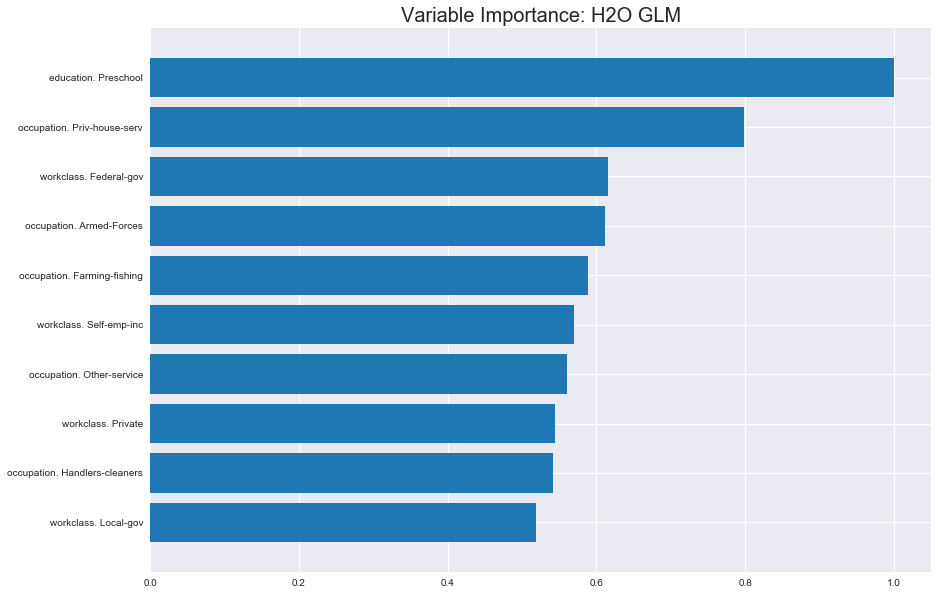

In [27]:
best.varimp_plot()

In [28]:
best.predict(gf)

predict,<=50K,>50K
<=50K,0.997053,0.00294736
<=50K,0.881809,0.118191
>50K,0.615354,0.384646
>50K,0.245103,0.754897
<=50K,0.99836,0.00164031
<=50K,0.995252,0.00474843
<=50K,0.989423,0.0105771
>50K,0.115269,0.884731
<=50K,0.993285,0.00671539
<=50K,0.950483,0.0495174


AUC: 0.9066950328309124

## GBM

#### PRE-PROCESSING FOR GBM


In [29]:
ss = hf.split_frame(seed = 1)
train_hf = ss[0]
valid_hf = ss[1]

### GBM WITHOUT HYPRERPARAMETERS

In [30]:
gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
gbm.train(x=predictors, y=response_col, training_frame=hf)

# Eval performance:
perf = gbm.model_performance(gf)

# Generate predictions on a test set:
pred = gbm.predict(gf)

In [31]:
gbm.model_performance(gf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.09033907842424388
RMSE: 0.30056459941956554
LogLoss: 0.2885572457637678
Mean Per-Class Error: 0.16016157654750096
AUC: 0.9234384268816671
AUCPR: 0.8176605598174321
Gini: 0.8468768537633342

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29262006582812056: 


,,<=50K,>50K,Error,Rate
0,<=50K,10688.0,1747.0,0.1405,(1747.0/12435.0)
1,>50K,728.0,3118.0,0.1893,(728.0/3846.0)
2,Total,11416.0,4865.0,0.152,(2475.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.292620,0.715876,228.0
1,max f2,0.184677,0.801689,272.0
2,max f0point5,0.570050,0.757417,131.0
3,max accuracy,0.503043,0.872428,153.0
4,max precision,0.983083,1.000000,0.0
5,max recall,0.010606,1.000000,397.0
6,max specificity,0.983083,1.000000,0.0
7,max absolute_mcc,0.405929,0.626779,187.0
8,max min_per_class_accuracy,0.258507,0.836349,241.0
9,max mean_per_class_accuracy,0.211048,0.839838,261.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.70 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.970993,4.233229,4.233229,1.000000,0.974792,1.000000,0.974792,0.042382,0.042382,323.322933,323.322933
1,,2,0.020023,0.967365,4.233229,4.233229,1.000000,0.969179,1.000000,0.971985,0.042382,0.084763,323.322933,323.322933
2,,3,0.030035,0.960682,4.233229,4.233229,1.000000,0.964553,1.000000,0.969508,0.042382,0.127145,323.322933,323.322933
3,,4,0.040047,0.945393,4.207259,4.226737,0.993865,0.953634,0.998466,0.965539,0.042122,0.169267,320.725860,322.673665
4,,5,0.050058,0.920521,4.181288,4.217647,0.987730,0.934491,0.996319,0.959330,0.041862,0.211128,318.128787,321.764689
5,,6,0.100055,0.734801,3.635169,3.926587,0.858722,0.802755,0.927563,0.881090,0.181747,0.392876,263.516867,292.658657
6,,7,0.150052,0.598405,2.792683,3.548774,0.659705,0.668582,0.838314,0.810283,0.139626,0.532501,179.268323,254.877350
7,,8,0.200049,0.473739,2.350638,3.249332,0.555283,0.535181,0.767578,0.741529,0.117525,0.650026,135.063840,224.933169
8,,9,0.300043,0.289117,1.625165,2.708054,0.383907,0.373741,0.639713,0.618958,0.162507,0.812533,62.516482,170.805356
9,,10,0.400037,0.169406,0.977699,2.275531,0.230958,0.224741,0.537540,0.520419,0.097764,0.910296,-2.230084,127.553138


AUC: 0.9234384268816671

### GBM WITH HYPERPARAMETERS

* MAX DEPTH

In [32]:
params = {'learn_rate': [0.01, 0.05, 0.1], 
          'ntrees': [50, 80, 110, 140],
          'sample_rate': [0.6,0.7,0.9], 
          'col_sample_rate': [0.3,0.5,0.6,0.8,1],
          'max_depth': list(range(3,30,4))
}


# Prepare the grid object
grid = H2OGridSearch(model=H2OGradientBoostingEstimator,   # Model to be trained
                     grid_id='grid',
                     hyper_params=params,              # Dictionary of parameters
                     search_criteria={"strategy": "RandomDiscrete"}   # RandomDiscrete
                     )

# Train the Model
grid.train(x=predictors,y=response_col, 
           training_frame=train_hf, 
           validation_frame=valid_hf,
           seed = 1111) # Grid Search ID

In [33]:
sorted_final_grid = grid.get_grid(sort_by='auc',decreasing = False)

In [34]:
sorted_final_grid

        col_sample_rate learn_rate max_depth ntrees sample_rate  \
0                   1.0       0.01         3     50         0.9   
1                   1.0       0.01         3     50         0.7   
2                   1.0       0.01         3     50         0.6   
3                   0.6       0.01         3     50         0.9   
4                   0.8       0.01         3     50         0.7   
5                   0.8       0.01         3     50         0.9   
6                   1.0       0.01         3     80         0.9   
7                   0.6       0.01         3     50         0.7   
8                   0.6       0.01         3     50         0.6   
9                   0.8       0.01         3     50         0.6   
10                  1.0       0.01         3     80         0.6   
11                  0.8       0.01         3     80         0.9   
12                  1.0       0.01         3     80         0.7   
13                  0.8       0.01         3     80         0.

In [35]:
best_model_id = sorted_final_grid.model_ids[0]

In [39]:
best_gbm_from_grid = h2o.get_model(best_model_id)
best_gbm_from_grid.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,7938.0,3.0,3.0,3.0,8.0,8.0,8.0


In [40]:
best_gbm_from_grid.model_performance(gf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13593960898877203
RMSE: 0.36869989013935445
LogLoss: 0.4332188957167972
Mean Per-Class Error: 0.2000902665780937
AUC: 0.8889643305876987
AUCPR: 0.7474813963283755
Gini: 0.7779286611753975

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2757134930243159: 


,,<=50K,>50K,Error,Rate
0,<=50K,10887.0,1548.0,0.1245,(1548.0/12435.0)
1,>50K,1168.0,2678.0,0.3037,(1168.0/3846.0)
2,Total,12055.0,4226.0,0.1668,(2716.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.275713,0.663528,78.0
1,max f2,0.185981,0.766913,115.0
2,max f0point5,0.319280,0.704871,64.0
3,max accuracy,0.319280,0.853203,64.0
4,max precision,0.538034,1.000000,0.0
5,max recall,0.157943,1.000000,124.0
6,max specificity,0.538034,1.000000,0.0
7,max absolute_mcc,0.319280,0.564415,64.0
8,max min_per_class_accuracy,0.246210,0.778991,88.0
9,max mean_per_class_accuracy,0.246210,0.799910,88.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.85 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010933,0.534197,4.185665,4.185665,0.988764,0.536015,0.988764,0.536015,0.045762,0.045762,318.566495,318.566495
1,,2,0.031325,0.516756,4.233229,4.216628,1.000000,0.520225,0.996078,0.525736,0.086323,0.132085,323.322933,321.662843
2,,3,0.040231,0.477814,4.174840,4.207378,0.986207,0.499968,0.993893,0.520032,0.037181,0.169267,317.483996,320.737755
3,,4,0.116086,0.420366,3.180920,3.536650,0.751417,0.423103,0.835450,0.456694,0.241290,0.410556,218.092050,253.665032
4,,5,0.154659,0.339186,2.534545,3.286721,0.598726,0.381368,0.776410,0.437908,0.097764,0.508320,153.454495,228.672094
5,,6,0.213378,0.306789,2.001485,2.933041,0.472803,0.313854,0.692861,0.403770,0.117525,0.625845,100.148500,193.304059
6,,7,0.320742,0.252698,1.421571,2.427095,0.335812,0.275247,0.573344,0.360748,0.152626,0.778471,42.157072,142.709472
7,,8,0.457650,0.244327,0.839429,1.952137,0.198295,0.244329,0.461146,0.325921,0.114925,0.893396,-16.057095,95.213743
8,,9,0.502303,0.185981,1.036472,1.870737,0.244842,0.196690,0.441917,0.314433,0.046282,0.939678,3.647156,87.073744
9,,10,0.637000,0.167077,0.270247,1.532306,0.063839,0.171374,0.361971,0.284182,0.036401,0.976079,-72.975280,53.230575


In [41]:
## SAVING THE MODEL 
path = "./model"
best_gbm_from_grid.save_mojo(path)

'/Users/vibhz/Desktop/PAPER/git/model/grid_model_458.zip'

In [ ]:
#to load the model 
#best_gbm = h2o.import_mojo(path)

## XGBoost 

In [27]:
import pandas as pd
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from h2o.estimators import H2OXGBoostEstimator

In [107]:
hf_xg=h2o.H2OFrame(train)
gf_xg=h2o.H2OFrame(test)

In [108]:
ss = hf_xg.split_frame(seed = 1)
train_hf = ss[0]
valid_hf = ss[1]

In [109]:
response_col = 'class'
predictors = list(train.columns.values)

In [113]:
train_hf, valid_hf = hf_xg.split_frame(ratios=[.8], seed=1234)

In [119]:
# Build and train the model:
xgb = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234)
xgb.train(x=predictors,
                  y=response_col,
                  training_frame=train_hf,
                  validation_frame=valid_hf)

In [120]:
# Eval performance:
perf = xgb.model_performance()

# Generate predictions on a test set (if necessary):
pred = xgb.predict(gf_xg)

In [117]:
perf


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07600587350318234
RMSE: 0.2756916275536534
LogLoss: 0.24158692801405215
Mean Per-Class Error: 0.12941071847789365
AUC: 0.9489243455438223
AUCPR: 0.8738142083530703
Gini: 0.8978486910876446

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42634533153426263: 


,,<=50K,>50K,Error,Rate
0,<=50K,18425.0,1406.0,0.0709,(1406.0/19831.0)
1,>50K,1455.0,4851.0,0.2307,(1455.0/6306.0)
2,Total,19880.0,6257.0,0.1095,(2861.0/26137.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.426345,0.772268,186.0
1,max f2,0.213079,0.837363,267.0
2,max f0point5,0.579807,0.808962,133.0
3,max accuracy,0.508557,0.892872,156.0
4,max precision,0.998791,1.000000,0.0
5,max recall,0.003150,1.000000,394.0
6,max specificity,0.998791,1.000000,0.0
7,max absolute_mcc,0.442322,0.701665,179.0
8,max min_per_class_accuracy,0.297753,0.867428,234.0
9,max mean_per_class_accuracy,0.260359,0.870589,248.0



Gains/Lift Table: Avg response rate: 24.13 %, avg score: 24.13 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010024,0.998459,4.144783,4.144783,1.000000,0.998834,1.000000,0.998834,0.041548,0.041548,314.478275,314.478275
1,,2,0.020010,0.997538,4.144783,4.144783,1.000000,0.998037,1.000000,0.998436,0.041389,0.082937,314.478275,314.478275
2,,3,0.030034,0.995852,4.144783,4.144783,1.000000,0.996856,1.000000,0.997909,0.041548,0.124485,314.478275,314.478275
3,,4,0.040020,0.990333,4.144783,4.144783,1.000000,0.993423,1.000000,0.996790,0.041389,0.165874,314.478275,314.478275
4,,5,0.050006,0.982207,4.144783,4.144783,1.000000,0.986687,1.000000,0.994772,0.041389,0.207263,314.478275,314.478275
5,,6,0.100011,0.769923,3.913284,4.029033,0.944147,0.877512,0.972073,0.936142,0.195687,0.402950,291.328379,302.903327
6,,7,0.150017,0.643369,3.190246,3.749437,0.769702,0.703809,0.904616,0.858698,0.159531,0.562480,219.024594,274.943749
7,,8,0.200023,0.513296,2.575030,3.455835,0.621270,0.575087,0.833780,0.787795,0.128766,0.691246,157.502953,245.583550
8,,9,0.299996,0.313562,1.659182,2.857104,0.400306,0.404844,0.689325,0.660177,0.165874,0.857120,65.918207,185.710378
9,,10,0.400008,0.163752,0.889527,2.365162,0.214614,0.234761,0.570636,0.553813,0.088963,0.946083,-11.047317,136.516249


In [118]:
pred

predict,<=50K,>50K
<=50K,0.997061,0.00293909
<=50K,0.786364,0.213636
>50K,0.541162,0.458838
>50K,0.00423998,0.99576
<=50K,0.999071,0.000929119
<=50K,0.99407,0.00592996
<=50K,0.988629,0.011371
>50K,0.0812949,0.918705
<=50K,0.991503,0.00849692
<=50K,0.947886,0.0521142


Gains/Lift Table: Avg response rate: 24.13 %, avg score: 24.13 %

AUC: 0.9489243455438223

#### Check these discussion

I am confused weather XGB can handel categorical data or not :(

https://www.kaggle.com/c/avito-demand-prediction/discussion/57094


https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e



### XGBoost Hyperparameter Tunning 

In [122]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [123]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [124]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [125]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [129]:
response_col = 'class'
predictors = list(train.columns.values)
predictors.remove('class')

In [130]:
grid_search.fit(predictors, response_col)

ValueError: Expected array-like (array or non-string sequence), got 'class'

In [ ]:
grid_search.best_estimator_